# All-in-One Workflow — Weeks 1–4

This notebook consolidates Weeks 1–4 with clear sections: environment + key columns, EDA, preprocessing, and baseline model.


## Simple loading — individual DataFrames then concat
We load each monthly CSV into its own DataFrame (df_1, df_2, …) and then combine them with a single pd.concat for simplicity.


In [1]:
from pathlib import Path
import re
import pandas as pd

DATA_DIR = Path.cwd()
RAW_PATTERN = re.compile(r"^CRMLSSold\d{6}.*\.csv$", re.I)

files = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and RAW_PATTERN.match(p.name)])
if not files:
    raise SystemExit("No CRMLS CSV files found.")

# Load each file into its own DataFrame
df_list = []
for i, p in enumerate(files, start=1):
    globals()[f"df_{i}"] = pd.read_csv(p, dtype=str, low_memory=False)
    df_list.append(globals()[f"df_{i}"])

# Combine
combined_raw = pd.concat(df_list, axis=0, ignore_index=True)
combined_raw.shape


(174802, 80)

In [2]:
# Minimal cleanup to align with later steps
combined = combined_raw.copy()
combined.columns = [c.strip() for c in combined.columns]
combined = combined.drop_duplicates()
combined.head(3)


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,latfilled,lonfilled
0,PasadenaFoothills,PasadenaFoothills,NaN,True,NaN,NaN,NaN,699000.0,538489291,jimo@bridgeadvisorsllc.com,...,NaN,False,NaN,NaN,90031,0.0,34350.0,NaN,False,False
1,BeverlyHillsGreaterLa,BeverlyHillsGreaterLa,"Carpet,Stone,Tile,Wood",True,NaN,True,True,45000.0,509724017,mwoods@marybethwoods.com,...,NaN,False,NaN,NaN,90402,NaN,5717.0,NaN,False,False
2,PalmSprings,PalmSprings,Tile,True,NaN,NaN,True,8500.0,498101084,encorepremiergroup@bdhomes.com,...,NaN,False,3.0,NaN,92270,1.0,4792.0,NaN,False,False


In [3]:
# Explicit simple loads (Week 1 & 2)
import pandas as pd

df1 = pd.read_csv('CRMLSSold202501_filled.csv')
df2 = pd.read_csv('CRMLSSold202502_filled.csv')
df3 = pd.read_csv('CRMLSSold202503_filled.csv')
df4 = pd.read_csv('CRMLSSold202504_filled.csv')
df5 = pd.read_csv('CRMLSSold202505_filled.csv')
df6 = pd.read_csv('CRMLSSold202506_filled.csv')
df7 = pd.read_csv('CRMLSSold202507_filled.csv')
# August held-out (test)
df8 = pd.read_csv('CRMLSSold202508_filled-2.csv')

# Combine (train months)
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)
len(df), len(df8)


/var/folders/_t/ms_9wggj1s1d3vr5j_zzp07c0000gn/T/ipykernel_25736/2597996614.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df6 = pd.read_csv('CRMLSSold202506_filled.csv')


(151830, 22972)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151830 entries, 0 to 151829
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   BuyerAgentAOR                 151763 non-null  object 
 1   ListAgentAOR                  151763 non-null  object 
 2   Flooring                      89371 non-null   object 
 3   ViewYN                        136929 non-null  object 
 4   WaterfrontYN                  99 non-null      object 
 5   BasementYN                    2506 non-null    object 
 6   PoolPrivateYN                 134351 non-null  object 
 7   OriginalListPrice             151357 non-null  float64
 8   ListingKey                    151830 non-null  int64  
 9   ListAgentEmail                151287 non-null  object 
 10  CloseDate                     151830 non-null  object 
 11  ClosePrice                    151828 non-null  float64
 12  ListAgentFirstName            151044 non-nul

In [5]:
df.describe()

,OriginalListPrice,ListingKey,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,FireplacesTotal,AboveGradeFinishedArea,...,ElementarySchoolDistrict,BelowGradeFinishedArea,CoveredSpaces,Stories,LotSizeArea,MainLevelBedrooms,GarageSpaces,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
count,1.513570e+05,1.518300e+05,1.518280e+05,151802.000000,151808.000000,1.410880e+05,1.515780e+05,151830.000000,0.0,0.0,...,0.0,692.000000,0.0,123184.000000,1.391980e+05,81327.000000,131513.000000,104459.000000,1.390890e+05,0.0
mean,9.099589e+05,1.104105e+09,8.744684e+05,34.524541,-118.451024,1.941091e+03,8.379714e+05,43.532029,NaN,NaN,...,NaN,60.290462,NaN,1.365502,4.714420e+04,1.923961,1.759381,190.005214,4.116788e+05,NaN
std,6.297255e+06,1.611421e+07,5.760117e+06,1.611195,3.288412,4.533451e+04,1.380965e+06,67.329311,NaN,NaN,...,NaN,342.116877,NaN,0.481573,1.398226e+06,2.356670,3.509902,2357.406969,1.858820e+07,NaN
min,0.000000e+00,4.216536e+08,0.000000e+00,-34.608007,-159.523315,0.000000e+00,0.000000e+00,-288.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,NaN
25%,2.400000e+04,1.100730e+09,2.000000e+04,33.732691,-118.532300,1.180000e+03,2.282950e+04,9.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,5.000000e+03,1.000000,1.000000,0.000000,5.227000e+03,NaN
50%,6.275000e+05,1.107603e+09,6.175000e+05,34.035516,-118.041352,1.582000e+03,6.199000e+05,22.000000,NaN,NaN,...,NaN,0.000000,NaN,1.000000,7.189500e+03,2.000000,2.000000,0.000000,7.401000e+03,NaN
75%,1.079000e+06,1.111814e+09,1.060000e+06,34.294150,-117.318511,2.160000e+03,1.050000e+06,54.000000,NaN,NaN,...,NaN,0.000000,NaN,2.000000,1.203375e+04,3.000000,2.000000,293.000000,1.347300e+04,NaN
max,1.390000e+09,1.120250e+09,9.700000e+08,47.684252,329.000000,1.702132e+07,1.375000e+08,3385.000000,NaN,NaN,...,NaN,6104.000000,NaN,2.000000,2.831400e+08,444.000000,500.000000,750000.000000,2.090880e+09,NaN


# All-in-One Workflow — Weeks 1–3

This notebook consolidates the Week 1, Week 2, and Week 3 deliverables into a single, clearly sectioned workflow.


## Part A — Week 1: Environment & Key Columns


In [1]:
# Environment & dataset access
import sys, shutil, platform
from pathlib import Path
import re
import pandas as pd

print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "git": shutil.which("git") is not None,
    "jupyter": True,
})

DATA_DIR = Path.cwd()
RAW_PATTERN = re.compile(r"^CRMLSSold\d{6}.*\.csv$", re.I)
raw_files = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and RAW_PATTERN.match(p.name)])
print(f"Found {len(raw_files)} CSV files")
raw_files[:5]


{'python': '3.12.4', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'git': True, 'jupyter': True}
Found 10 CSV files


[PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202501_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202502_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202503_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202504_filled.csv'),
 PosixPath('/Users/anvith/Downloads/Datasets IDX/CRMLSSold202505_filled.csv')]

In [2]:
# Key columns notes
sample_path = raw_files[0]
df_sample = pd.read_csv(sample_path, nrows=200, dtype=str, low_memory=False)

key_columns = {
    "ClosePrice": "Final sales price at closing; target.",
    "CloseDate": "Sale closed date; time-aware split/temporal features.",
    "LivingArea": "Interior living area (sq ft).",
    "BedroomsTotal": "Number of bedrooms.",
    "BathroomsTotalInteger": "Number of bathrooms (integer).",
    "LotSizeAcres": "Lot size in acres.",
    "YearBuilt": "Year built.",
    "Latitude": "Latitude coordinate.",
    "Longitude": "Longitude coordinate.",
    "PostalCode": "ZIP/postal code for neighborhood aggregation.",
    "PropertyType": "High-level property type (filter to Residential).",
    "PropertySubType": "Detailed type (filter to SingleFamilyResidence).",
}

actual_cols = list(df_sample.columns)
matched, unmatched = {}, []
for k, note in key_columns.items():
    m = next((c for c in actual_cols if k.lower() == c.lower() or k.lower() in c.lower()), None)
    if m:
        matched[m] = note
    else:
        unmatched.append(k)

print("Matched key columns:")
for c, note in matched.items():
    print(f"- {c}: {note}")

if unmatched:
    print("\nUnmatched (review/rename as needed):")
    for k in unmatched:
        print(f"- {k}")


Matched key columns:
- ClosePrice: Final sales price at closing; target.
- CloseDate: Sale closed date; time-aware split/temporal features.
- LivingArea: Interior living area (sq ft).
- BedroomsTotal: Number of bedrooms.
- BathroomsTotalInteger: Number of bathrooms (integer).
- LotSizeAcres: Lot size in acres.
- YearBuilt: Year built.
- Latitude: Latitude coordinate.
- Longitude: Longitude coordinate.
- PostalCode: ZIP/postal code for neighborhood aggregation.
- PropertyType: High-level property type (filter to Residential).
- PropertySubType: Detailed type (filter to SingleFamilyResidence).


## Part B — Week 2: Exploration (Residential SFR)


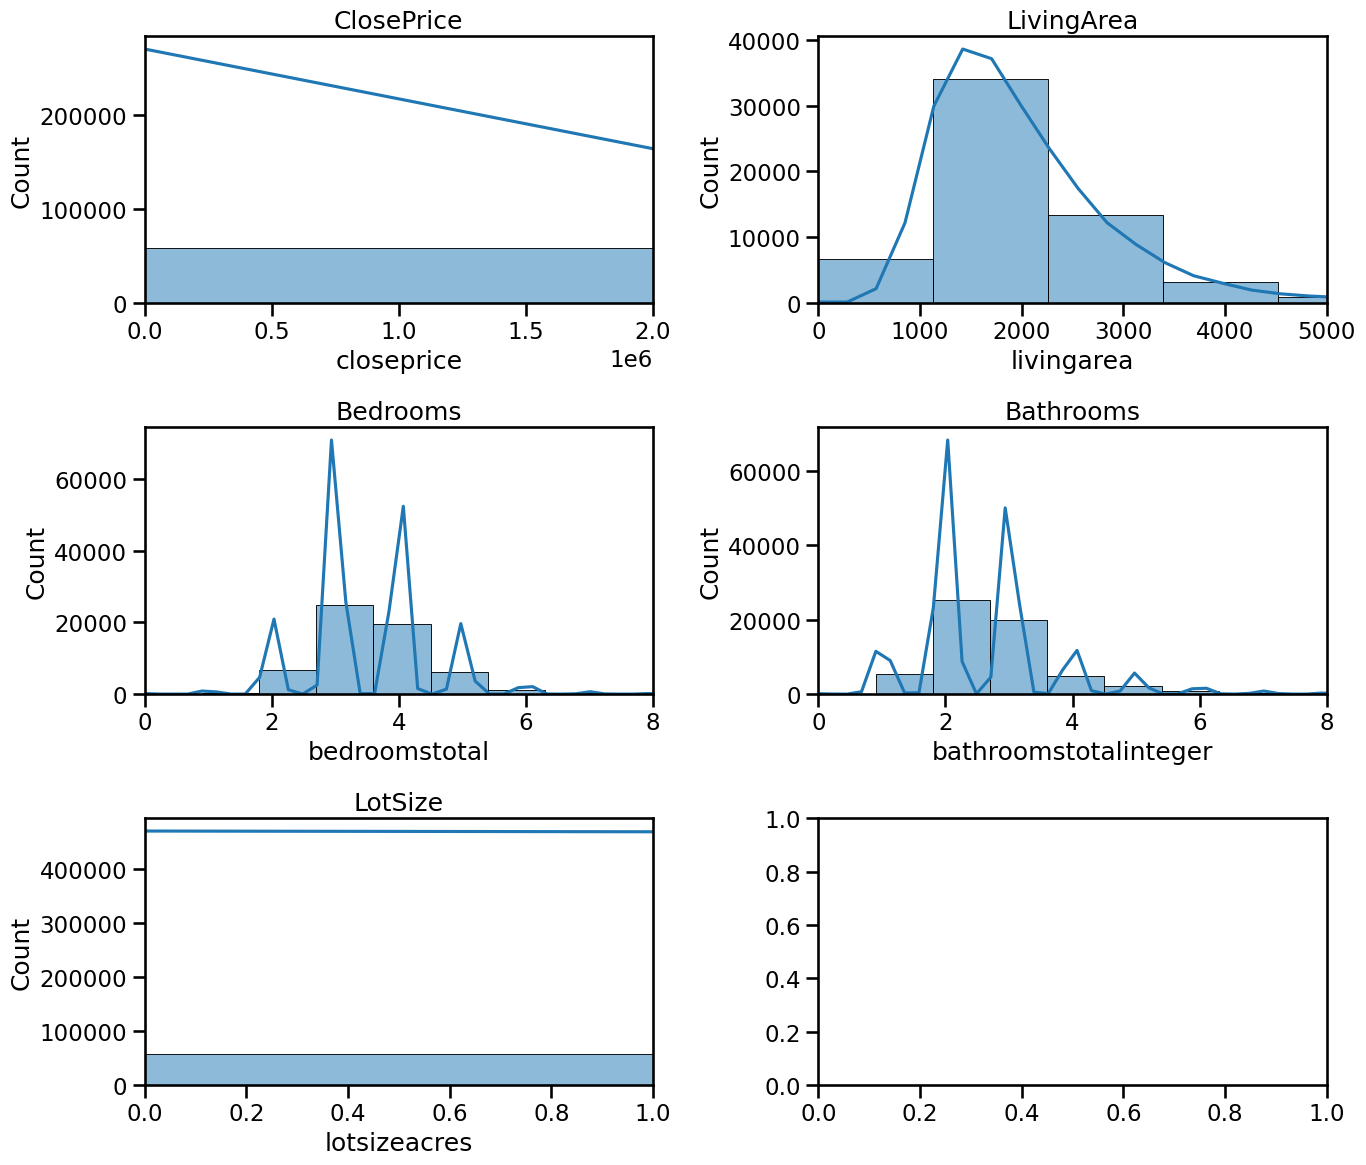

In [2]:
# Select recent files and standardize
import seaborn as sns
import matplotlib.pyplot as plt

files = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and RAW_PATTERN.match(p.name)])

def yyyymm(p):
    m = re.search(r"CRMLSSold(\d{6})", p.name)
    return int(m.group(1)) if m else 0

files = sorted(files, key=yyyymm)
selected = files[-12:] if len(files) >= 12 else files[-7:] if len(files) >= 7 else files

sns.set_context("talk")

def std_columns(cols):
    out, seen = [], {}
    for c in cols:
        s = re.sub(r"\s+", "_", c.strip()).lower()
        s = s.replace("/", "_").replace("\\", "_")
        s = s.replace("(", "").replace(")", "")
        s = s.replace("%", "pct").replace("#", "num").replace("$", "usd").replace("-", "_").replace(".", "_")
        s = re.sub(r"[^0-9a-z_]+", "", s)
        s = re.sub(r"_+", "_", s).strip("_")
        if not s: s = "col"
        if s in seen:
            seen[s] += 1
            s = f"{s}_{seen[s]}"
        else:
            seen[s] = 0
        out.append(s)
    return out

frames = []
for p in selected:
    d = pd.read_csv(p, dtype=str, low_memory=False)
    d.columns = std_columns(d.columns)
    frames.append(d)

dfe = pd.concat(frames, axis=0, ignore_index=True).drop_duplicates()

cols = {c.lower(): c for c in dfe.columns}
ptype = next((cols[k] for k in cols if k in ("propertytype","property_type")), None)
psub = next((cols[k] for k in cols if k in ("propertysubtype","property_subtype")), None)

flt = dfe.copy()
if ptype is not None:
    flt = flt[flt[ptype].str.strip().str.lower() == "residential"]
if psub is not None:
    flt = flt[flt[psub].str.strip().str.lower() == "singlefamilyresidence"]

ALIASES = {
    "closeprice": ["close_price","closeprice","sold_price","sale_price","final_sales_price","final_price","closing_price"],
    "livingarea": ["living_area","livingarea","sqft","square_feet","square_footage"],
    "bedrooms": ["bedrooms","bedroomstotal","beds"],
    "bathrooms": ["bathrooms","bathroomstotalinteger","baths"],
    "lotsize": ["lotsizeacres","lot_size_acres","lot_size","lotsize","acres"],
}

name_map = {}
for key, cands in ALIASES.items():
    found = next((c for c in flt.columns if any(x in c for x in cands)), None)
    name_map[key] = found

import numpy as np

def to_num(s):
    if s is None: return None
    x = s.astype(str).str.replace(",","", regex=False).str.replace("$","", regex=False)
    return pd.to_numeric(x, errors="coerce")

series = {
    "ClosePrice": to_num(flt[name_map["closeprice"]]) if name_map["closeprice"] else None,
    "LivingArea": to_num(flt[name_map["livingarea"]]) if name_map["livingarea"] else None,
    "Bedrooms": to_num(flt[name_map["bedrooms"]]) if name_map["bedrooms"] else None,
    "Bathrooms": to_num(flt[name_map["bathrooms"]]) if name_map["bathrooms"] else None,
    "LotSize": to_num(flt[name_map["lotsize"]]) if name_map["lotsize"] else None,
}

cols = 2
fig, axes = plt.subplots(3, cols, figsize=(14, 12))
axes = axes.flatten()
limits = [(0, 2_000_000), (0, 5000), (0, 8), (0, 8), (0, 1.0)]
for i, (key, ser) in enumerate(series.items()):
    ax = axes[i]
    if ser is None:
        ax.axis('off')
        ax.set_title(f"{key} (missing)")
        continue
    s = ser.dropna()
    if len(s) == 0:
        ax.axis('off')
        ax.set_title(f"{key} (no data)")
        continue
    sns.histplot(s, kde=True, bins=50, ax=ax)
    ax.set_title(key)
    ax.set_xlim(left=limits[i][0], right=limits[i][1])

plt.tight_layout()
plt.show()


## Part C — Week 3: Preprocessing, Encoding, Split, and Cleaned CSV


In [3]:
# Load all files, standardize, and label months (reuse functions)

def get_yyyymm(p: Path) -> int:
    m = re.search(r"CRMLSSold(\d{6})", p.name)
    return int(m.group(1)) if m else 0

files_all = sorted([p for p in DATA_DIR.iterdir() if p.is_file() and RAW_PATTERN.match(p.name)], key=get_yyyymm)

def std_columns(cols):
    out, seen = [], {}
    for c in cols:
        s = re.sub(r"\s+", "_", c.strip()).lower()
        s = s.replace("/", "_").replace("\\", "_")
        s = s.replace("(", "").replace(")", "")
        s = s.replace("%", "pct").replace("#", "num").replace("$", "usd").replace("-", "_").replace(".", "_")
        s = re.sub(r"[^0-9a-z_]+", "", s)
        s = re.sub(r"_+", "_", s).strip("_")
        if not s: s = "col"
        if s in seen:
            seen[s] += 1
            s = f"{s}_{seen[s]}"
        else:
            seen[s] = 0
        out.append(s)
    return out

import pandas as pd

def load_with_month(p: Path) -> pd.DataFrame:
    d = pd.read_csv(p, dtype=str, low_memory=False)
    d.columns = std_columns(d.columns)
    header_tuple = tuple(d.columns)
    mask = d.apply(lambda r: tuple(r.astype(str)) == header_tuple, axis=1)
    if mask.any():
        d = d.loc[~mask].copy()
    d["source_yyyymm"] = get_yyyymm(p)
    return d

frames = [load_with_month(p) for p in files_all]
dfw3 = pd.concat(frames, axis=0, ignore_index=True).drop_duplicates()
dfw3.shape, dfw3["source_yyyymm"].min(), dfw3["source_yyyymm"].max()


((174777, 81), 202501, 202508)

In [4]:
# Feature selection, missing values, and outliers (same approach as Week 3 notebook)
TARGET_CANDS = ["close_price","closeprice","sold_price","sale_price","final_sales_price","final_price","closing_price"]
DATE_CANDS = ["close_date","closedate","sold_date","solddate","closing_date","closingdate"]

cols_lower = {c.lower(): c for c in dfw3.columns}
TARGET = next((cols_lower[c] for c in TARGET_CANDS if c in cols_lower), None)
if TARGET is None:
    TARGET = next((c for c in dfw3.columns if any(k in c for k in TARGET_CANDS)), None)
if TARGET is None:
    raise SystemExit("Could not detect ClosePrice target column.")

DATE_COL = next((cols_lower[c] for c in DATE_CANDS if c in cols_lower), None)
if DATE_COL:
    dfw3[DATE_COL] = pd.to_datetime(dfw3[DATE_COL], errors="coerce")

LEAK = ["listprice","originallistprice","list_price","listing","dom","days_on_market","daysonmarket","status","agent","broker","office","remarks","marketing","virtual","photo","syndication","license","member","mls"]
PROP = ["bed","bath","living_area","livingarea","sqft","square_feet","lot","lot_size","acres","year_built","yearbuilt","stories","units","pool","spa","garage","parking","hoa","zoning"]
LOC  = ["latitude","longitude","lat","lon","lng","zip","zipcode","postal","postalcode","city","county","neighborhood","school","district"]

features = []
for c in dfw3.columns:
    if c == TARGET: continue
    low = c.lower()
    if any(k in low for k in LEAK):
        continue
    if any(k in low for k in PROP) or any(k in low for k in LOC) or (DATE_COL and c == DATE_COL):
        features.append(c)

import numpy as np

def to_num(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s
    x = s.astype(str).str.replace(",","", regex=False).str.replace("$","", regex=False).str.replace("%","", regex=False)
    return pd.to_numeric(x, errors="coerce")

work = dfw3[features + [TARGET, "source_yyyymm"]].copy()
work[TARGET] = to_num(work[TARGET])

AREA_CANDS = ["living_area","livingarea","sqft","square_feet","square_footage"]
area_col = next((c for c in AREA_CANDS if c in work.columns), None)
if area_col is not None:
    work[area_col] = to_num(work[area_col])

beds_col = next((c for c in ["bedroomstotal","beds","bedrooms"] if c in work.columns), None)
if beds_col is not None:
    work[beds_col] = to_num(work[beds_col])

baths_col = next((c for c in ["bathroomstotalinteger","baths","bathrooms"] if c in work.columns), None)
if baths_col is not None:
    work[baths_col] = to_num(work[baths_col])

lot_col = next((c for c in ["lotsizeacres","lot_size_acres","lot_size","lotsize","acres"] if c in work.columns), None)
if lot_col is not None:
    work[lot_col] = to_num(work[lot_col])

zip_col = next((c for c in ["zip","zipcode","postal","postalcode"] if c in work.columns), None)
for c in [area_col, beds_col, baths_col, lot_col]:
    if c:
        work[f"{c}_was_missing"] = work[c].isna().astype(int)

if zip_col:
    for c in [area_col, beds_col, baths_col, lot_col]:
        if c:
            med_by_zip = work.groupby(zip_col)[c].median()
            work[c] = work[c].fillna(work[zip_col].map(med_by_zip))

for c in [area_col, beds_col, baths_col, lot_col]:
    if c:
        work[c] = work[c].fillna(work[c].median())

work = work.dropna(subset=[TARGET]).copy()

logp = np.log1p(work[TARGET].clip(lower=0))
q1, q3 = logp.quantile(0.25), logp.quantile(0.75)
iqr = q3 - q1
keep = (logp >= (q1 - 3*iqr)) & (logp <= (q3 + 3*iqr))
work = work.loc[keep].copy()
work.shape


(174775, 35)

In [5]:
# Encoding, normalization, and time-based split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

X = work.drop(columns=[TARGET])
y = work[TARGET].astype(float)

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_t = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

categorical_t = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=20)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_t, num_cols),
        ("cat", categorical_t, cat_cols),
    ],
    remainder="drop",
)

# Time-based split:
# Use latest August (YYYY08) as the test set if present; otherwise fall back to most recent month.
months = sorted(work["source_yyyymm"].unique())
if len(months) < 2:
    raise SystemExit("Not enough months for a time-based split.")

august_months = [m for m in months if (m % 100) == 8]
if len(august_months) > 0:
    test_month = max(august_months)  # latest August available
else:
    test_month = months[-1]  # fallback to most recent month

# Train months: earliest five months strictly before the test month (or all available if <5)
train_candidates = [m for m in months if m < test_month]
train_months = train_candidates[:5] if len(train_candidates) >= 5 else train_candidates

train_idx = work[work["source_yyyymm"].isin(train_months)].index
test_idx = work[work["source_yyyymm"] == test_month].index

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

X_train.shape, X_test.shape, {"train_months": train_months, "test_month": test_month}


((105289, 34),
 (22966, 34),
 {'train_months': [202501, 202502, 202503, 202504, 202505],
  'test_month': 202508})

In [6]:
# Save cleaned CSV
cleaned = work.copy()
cleaned_path = DATA_DIR / "cleaned_week3.csv"
cleaned.to_csv(cleaned_path, index=False)
cleaned_path


PosixPath('/Users/anvith/Downloads/Datasets IDX/cleaned_week3.csv')

## Part D — Week 4: Baseline Linear Regression (Moved to Bottom)


In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

DATA_DIR = Path.cwd()
CLEAN_PATH = DATA_DIR / "cleaned_week3.csv"

if not CLEAN_PATH.exists():
    raise SystemExit("cleaned_week3.csv not found. Run Week 3 preprocessing to generate it.")

work = pd.read_csv(CLEAN_PATH, low_memory=False)

TARGET_CANDS = ["close_price","closeprice","sold_price","sale_price","final_sales_price","final_price","closing_price"]
cols_lower = {c.lower(): c for c in work.columns}
TARGET = next((cols_lower[c] for c in TARGET_CANDS if c in cols_lower), None)
if TARGET is None:
    TARGET = next((c for c in work.columns if any(k in c for k in TARGET_CANDS)), None)
if TARGET is None:
    raise SystemExit("Could not detect target column in cleaned data.")

X = work.drop(columns=[TARGET])
y = work[TARGET].astype(float)

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_t = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

categorical_t = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=20)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_t, num_cols),
        ("cat", categorical_t, cat_cols),
    ],
    remainder="drop",
)

months = sorted(work["source_yyyymm"].unique()) if "source_yyyymm" in work.columns else []
if months:
    august_months = [m for m in months if (m % 100) == 8]
    test_month = max(august_months) if august_months else months[-1]
    train_candidates = [m for m in months if m < test_month]
    train_months = train_candidates[:5] if len(train_candidates) >= 5 else train_candidates
    train_idx = work[work["source_yyyymm"].isin(train_months)].index
    test_idx = work[work["source_yyyymm"] == test_month].index
else:
    from sklearn.model_selection import train_test_split
    train_idx, test_idx = train_test_split(X.index, test_size=0.2, random_state=42)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

pipe = Pipeline(steps=[("prep", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)

r2 = r2_score(y_test, pipe.predict(X_test))
print({"R2_baseline": r2, "test_month": int(test_month if months else -1)})


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['elementaryschooldistrict' 'coveredspaces' 'middleorjuniorschooldistrict']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


{'R2_baseline': 0.0025546874122571728, 'test_month': 202508}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['elementaryschooldistrict' 'coveredspaces' 'middleorjuniorschooldistrict']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
